# Deep Learning with PyTorch : Build a Generative Adversarial Network 

In [1]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

# Configurations

In [2]:
device = 'cuda' # image = image.to(device)

batch_size= 128  # trainloader, training loop

noise_dim = 64  # generator model

#optimizers parameters

lr = 0.0002
beta_1 = 0.5
beta_2= 0.99

#training variables

epochs = 20

# Load MNIST Dataset 

In [3]:
from torchvision import datasets, transforms as T 

In [4]:
train_args = T.Compose([ T.RandomRotation((-20, +20)),
                        T.ToTensor() # (h,w,c) -> (c,h,w)
                        ])

In [5]:
trainset = datasets.MNIST('MNIST/', download= True, train= True, transform= train_args)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



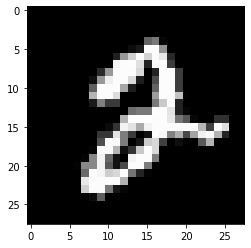

In [6]:
image, label = trainset[5]

plt.imshow(image.squeeze(), cmap = 'gray')

In [7]:
print("total images present in trainset are : ", len(trainset))

total images present in trainset are :  60000


# Load Dataset Into Batches 

In [8]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [9]:
trainloader = DataLoader(trainset, batch_size= batch_size, shuffle= True)

In [10]:
print("total no of batches om trainloder : ", len(trainloader))

total no of batches om trainloder :  469


In [11]:
dataiter = iter(trainloader)

images, _ = dataiter.next()

print(images.shape)

torch.Size([128, 1, 28, 28])


In [12]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

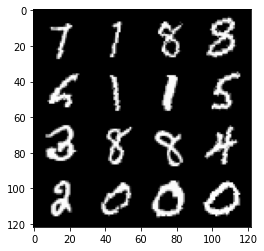

In [13]:
show_tensor_images(images, num_images= 16 )

# Create Discriminator Network 

In [14]:
#In case if torch summary is not installed 

!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from torch import nn
from torchsummary import summary

In [16]:
from torch.nn.modules.batchnorm import BatchNorm2d
def get_disc_block(in_channels, out_channels, kernal_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernal_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [17]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1 = get_disc_block(1, 16 , (3,3), 2 )
    self.block_2 = get_disc_block(16, 32, (5,5), 2)
    self.block_3 = get_disc_block(32, 64, (5,5), 2)
    
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=64, out_features=1)


  def forward(self, images):

    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    
    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5 

# no sigmoid layer bcz binary cross entropy with logit loss takes raw ouput 

In [18]:
D =  Discriminator()
D.to(device)

summary(D, input_size=( 1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network 

In [19]:
def get_gen_block(in_channels, out_channels, kernal_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernal_size, stride),
        nn.Tanh()
    )
  
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernal_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [20]:
class Generator(nn.Module):

  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim

    self.block_1 = get_gen_block(noise_dim, 256 ,(3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)
    self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block=True)

  def forward(self, r_noise_vec):
    
    #(bs, noise_dm) --> (bs, noise_dim, 1, 1)
    x = r_noise_vec.view(-1, self.noise_dim, 1, 1 )

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4 


In [21]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size= (1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [22]:
# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [23]:
D = D.apply(weights_init)
G = G.apply(weights_init) 

# Create Loss Function and Load Optimizer

In [24]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [25]:
D_opt = torch.optim.Adam(D.parameters(), lr =lr , betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr =lr , betas=(beta_1, beta_2))

# Training Loop 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 1 | D_loss : 0.68553391588268 | G_loss : 0.6893599046064592


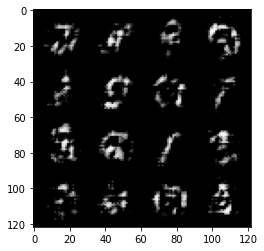

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 2 | D_loss : 0.677279611259127 | G_loss : 0.7124223043161161


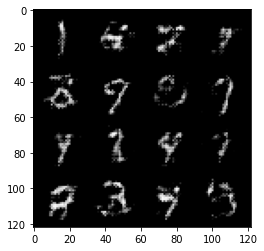

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 3 | D_loss : 0.6424638715380037 | G_loss : 0.7521042156575332


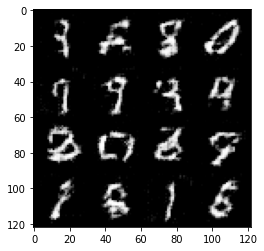

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 4 | D_loss : 0.618461929658837 | G_loss : 0.7863991793030615


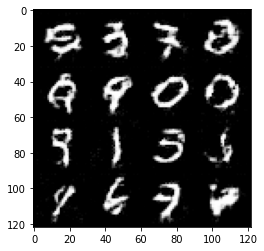

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 5 | D_loss : 0.6090083617899718 | G_loss : 0.8074418292370941


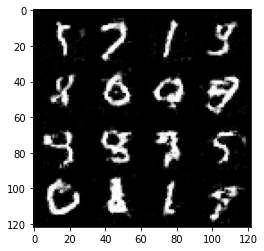

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 6 | D_loss : 0.6106476012323456 | G_loss : 0.817590037388588


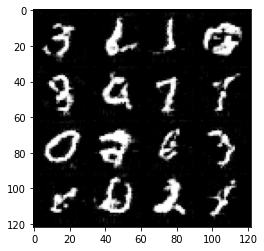

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 7 | D_loss : 0.6159145875271957 | G_loss : 0.8210239956882208


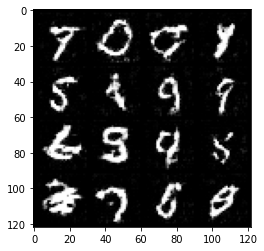

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 8 | D_loss : 0.6214524338494486 | G_loss : 0.8186876860254609


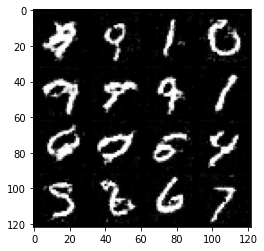

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 9 | D_loss : 0.6268885687216005 | G_loss : 0.8201259195423329


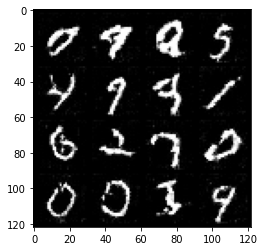

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 10 | D_loss : 0.6310580916750406 | G_loss : 0.8162330279726464


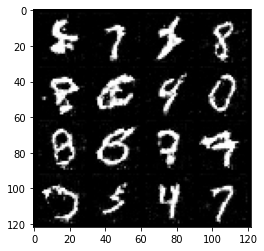

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 11 | D_loss : 0.6333752452437558 | G_loss : 0.8156306082760093


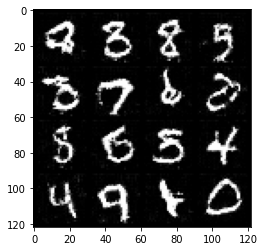

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 12 | D_loss : 0.6362768392573034 | G_loss : 0.8140509943209732


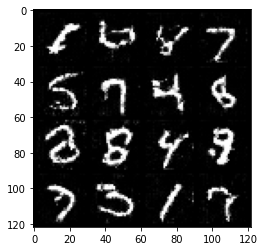

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 13 | D_loss : 0.6375375306174191 | G_loss : 0.8099545921598162


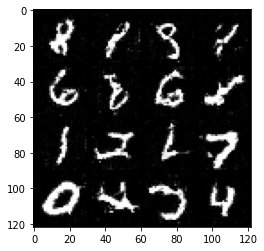

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 14 | D_loss : 0.6391365976730136 | G_loss : 0.8114499326453788


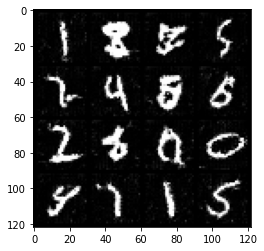

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 15 | D_loss : 0.6404940816385152 | G_loss : 0.81221109984526


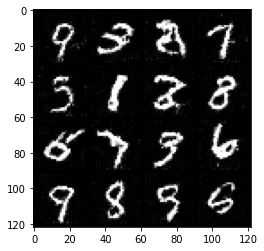

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 16 | D_loss : 0.6415666282049882 | G_loss : 0.809184868198468


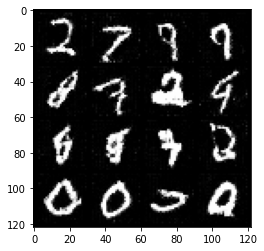

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 17 | D_loss : 0.641216195595544 | G_loss : 0.8109278267126347


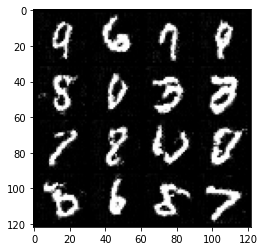

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 18 | D_loss : 0.6406171645945323 | G_loss : 0.8123176945552134


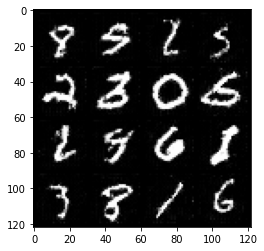

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 19 | D_loss : 0.6427795709069095 | G_loss : 0.8098693506549924


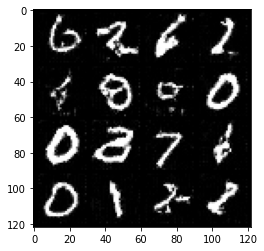

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 20 | D_loss : 0.6436428727625784 | G_loss : 0.8103835854703175


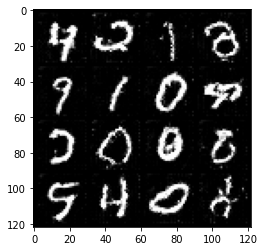

In [26]:
for i in range(epochs):
  
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in trainloader:
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device= device)

  #find loss and update weight for D 

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss= (D_fake_loss + D_real_loss)/2

    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    #find loss and update weight for G

    G_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss/ len(trainloader)
  avg_g_loss = total_g_loss/ len(trainloader)

  print("Epoch : {} | D_loss : {} | G_loss : {}".format(i+1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


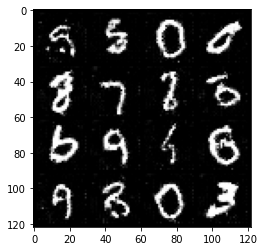

In [27]:
# use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)